## IMAGE RESTORATION USING WIENER FILTER AND CONSTRAINT LEAST SQUARE FILTER

#### WIENER FILTER: Wiener filter is a filter used to produce an estimate of a desired or target random process by linear time-invariant (LTI) filtering of an observed noisy process, assuming known stationary signal and noise spectra, and additive noise. The Wiener filter minimizes the mean square error between the estimated random process and the desired process.In Image Processing the Wiener filter is used to remove noise from a picture

#### History: The filter was proposed by Norbert Wiener during the 1940s and published in 1949.The discrete-time equivalent of Wiener's work was derived independently by Andrey Kolmogorov and published in 1941. Hence the theory is often called the Wiener–Kolmogorov filtering theory.The Wiener filter was the first statistically designed filter to be proposed and subsequently gave rise to many others including the Kalman filter.

#### Wiener Filter in Image Processing: The Wiener Filter is the most important technique for removal of blur in images due to linear motion or unfocussed optics.
From a signal processing standpoint, blurring due to linear motion in a photograph is the result of poor sampling. Each pixel in a digital representation of the photograph should represent the intensity of a single stationary point in front of the camera.
Unfortunately, if the shutter speed is too slow and the camera is in motion, a given pixel will be an amalgram of intensities from points along the line of the camera's motion. This is a two-dimensional analogy to G(u,v)=F(u,v).H(u,v) where F is the fourier transform of an "ideal" version of a given image, and H is the blurring function. In this case H is a sinc function: if three pixels in a line contain info from the same point on an image, the digital image will seem to have been convolved with a three-point boxcar in the time domain. Ideally one could reverse-engineer a Fest, or F estimate, if G and H are known. This technique is inverse fitering.

#### Import Libraries

In [1]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt


#### Define Blurring Function

In [2]:
def blur(img, mode = 'box', kernel_size = 3):
    # mode = 'box' or 'gaussian' or 'motion'
    dummy = np.copy(img)
    if mode == 'box':
        h = np.ones((kernel_size, kernel_size)) / kernel_size ** 2
    elif mode == 'gaussian':
        h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
    elif mode == 'motion':
        h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

#### Define function to add Gaussian Noise

In [3]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

#### Define Wiener Filter Function

In [4]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

#### Define Function For Gaussian Kernel

In [5]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

#### Define Function to convert RGB color to Gray color image

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [7]:
# Load image and convert it to gray scale 
img = rgb2gray(plt.imread('Ladder.jpeg'))

# Blur the image
blurred_img = blur(img, mode = 'motion', kernel_size = 3)

# Add Gaussian noise
noisy_img = add_gaussian_noise(blurred_img, sigma = 20)

# Apply Wiener Filter
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(noisy_img, kernel, K = 30)

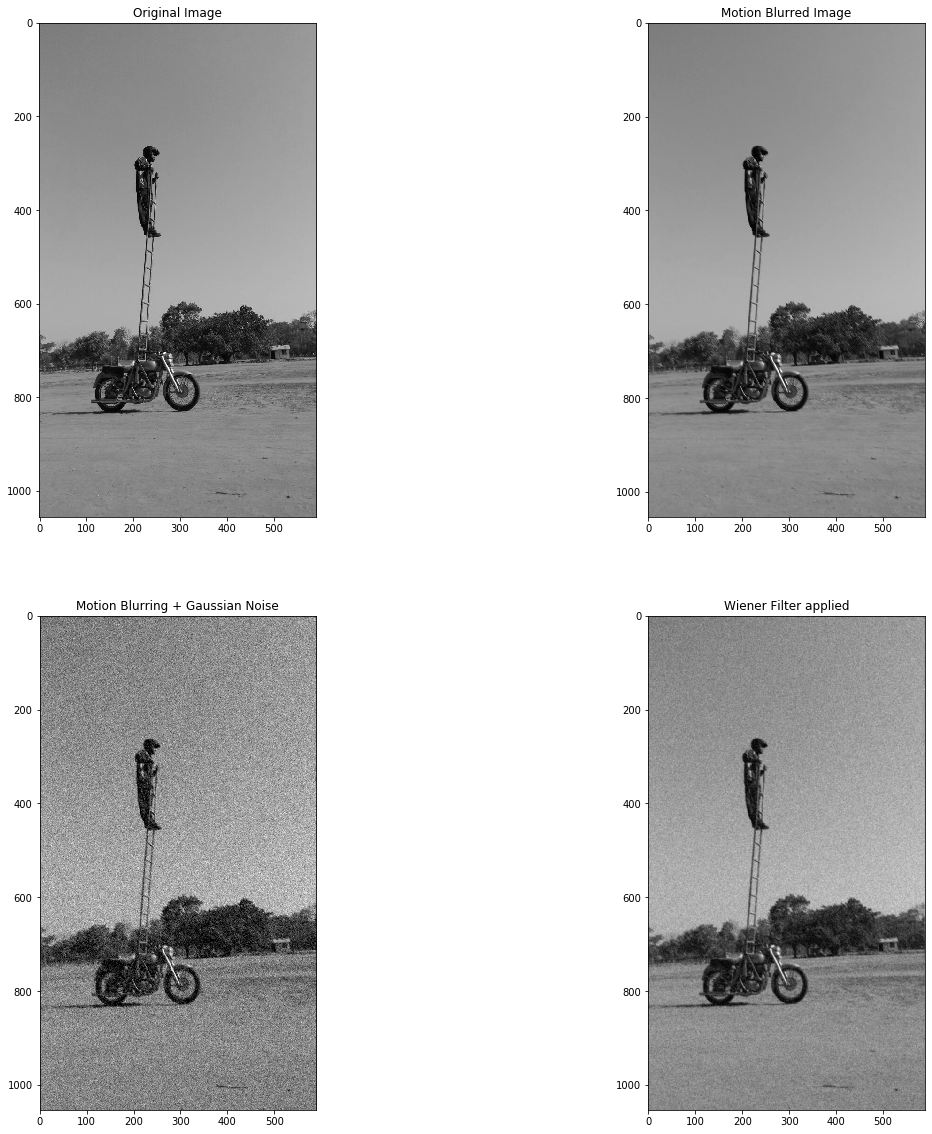

In [8]:
# Display results
display = [img, blurred_img, noisy_img, filtered_img]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(20, 20))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

#### Wiener Filter is used to denoise and deblur noisy images corrupted by Gaussian noise and motion blurring. The implemented filter was tested on the Ladder image with the resolutions of 592x1056 and 96x96 pixels

In [9]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import color, data, restoration
from skimage.restoration import wiener, unsupervised_wiener
from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#### CONSTRAINT LEAST SQUARE FILTER

#### Constrained least-squares image restoration, first proposed by Hunt twenty years ago, is a linear image restoration technique in which the smoothness of the restored image is maximized subject to a constraint on the fidelity of the restored image.

#### This CLS filter and it's variants is probably one of the most common utilized restoration filter. It simply turns an unconstrained least squares of optimization problem into a constrained one. It restricts the solution space of the least squares approach. By incorporating into the problem prior knowledge about the solution.

#### Bases optimality of restoration on a measure of smoothness. Seek minimum of a criterion function
                           C =∑_(x=0)^(M-1)▒〖∑_(x=0)^(N-1)▒〖[∇^2 〗 f(x,y)]〗^2   (second derivative)
 From the degradation system we get 
                           g(x, y) = h(x, y) ∗ f(x, y) + η(x, y)
                           g = Hf + η (vector-matrix form)

The criterion function is subject to the constraint 
                        ‖g-Hf ̂ ‖^2 =  ‖η‖ 
where f’ is an estimate of the undegraded image. The frequency domain solution thus becomes 
                              F ̂(u, v) =     [(H* (u,v) )/(〖|H(u,v)| 〗^2  + 〖γ|P(u,v)|〗^2 )] G(u, v) 
where γ is the parameter to be adjusted (γ = 0 ⇒ inverse filtering), and P(u, v) is the fourier transform of the function.


#### Define Constraint Linear Square Filter Function

In [10]:
def cls_filter(y,h,c,lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + lambd*Cf*np.conj(Cf))
    #Hf = np.abs(Hf)**2 / (np.abs(Hf)**2 + lambd*np.abs(Cf)**2)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf)

#### Define Constraint Linear Square Filter Function

In [11]:
def pseudo_inverse_filter(y, h, epsilon):
        
    Hf = fp.fft2(fp.ifftshift(h))
    M, N = Hf.shape
    Hf[(np.abs(Hf)<epsilon)] = 0
    indices = np.where((np.abs(Hf)>=epsilon))
    Hf[indices] = np.ones((M,N))[indices] / Hf[indices]
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf)

(1056, 592)


Text(0.5, 1.0, 'Restored (Unsup.Wiener)\nPSNR: 26.498')

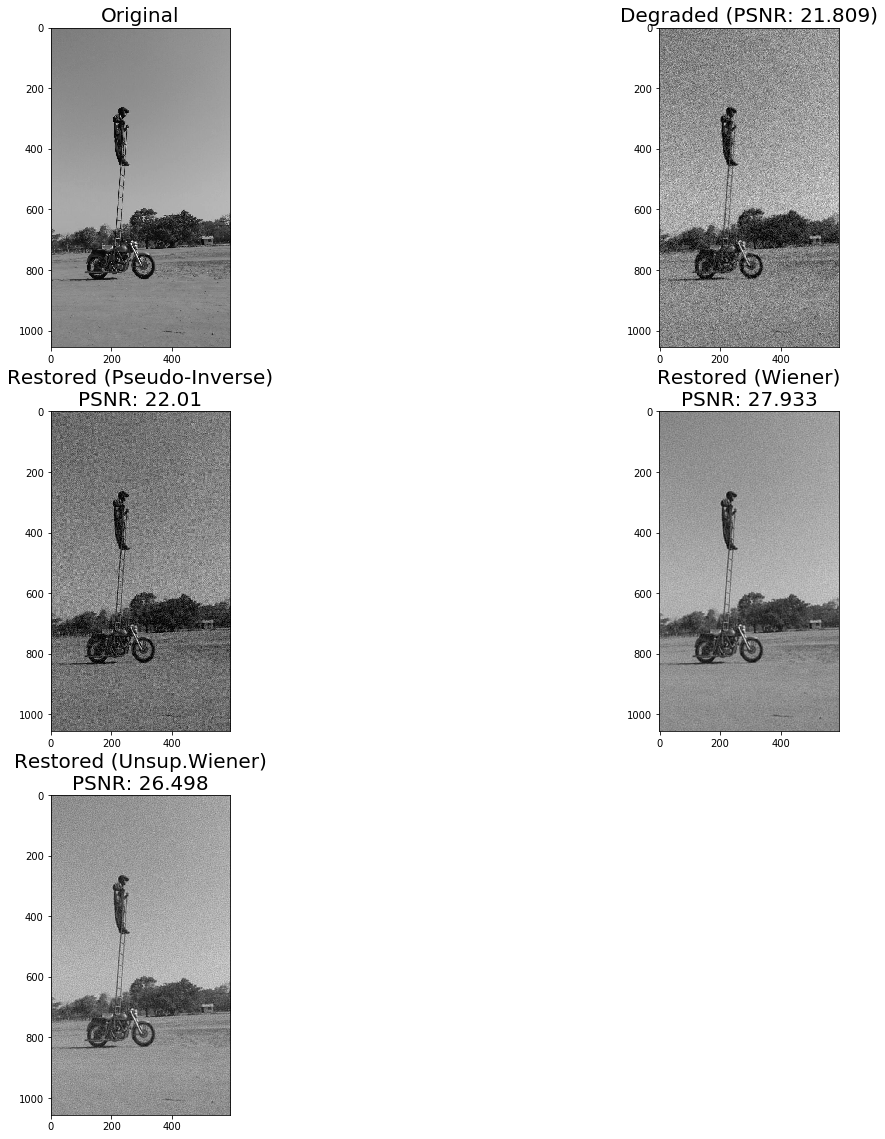

In [12]:
fig = plt.figure(figsize=(20,20))
# Input and display the binary image
x = rgb2gray(imread('Ladder.jpeg'))
print(x.shape)
M, N = x.shape

plt.subplot(3,2,1)
plt.imshow(x, cmap='gray')
plt.title('Original', size=20)

# Blur the image, corrupt the image using WGN and display it
# h is the blurring filter, and sigma is the noise std
h = np.ones((4,4))/16
h = np.pad(h, [(M//2-2, M//2-2), (N//2-2, N//2-2)], mode='constant')
sigma = 0.075
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

Y = Hf*Xf
y = fp.ifft2(Y).real + sigma*np.random.normal(size=(M,N))

plt.subplot(3,2,2)
plt.imshow(np.abs(y), cmap='gray')
plt.title('Degraded (PSNR: {})'.format(np.round(peak_signal_noise_ratio(x, y),3)), size=20)

# restoration using inverse filtering
epsilon = 0.25
pix, F_pseudo = pseudo_inverse_filter(y, h, epsilon)
plt.subplot(3,2,3)
plt.imshow(pix, cmap='gray')
plt.title('Restored (Pseudo-Inverse)\nPSNR: {}'.format(np.round(peak_signal_noise_ratio(x, pix),3)), size=20)

# restoration using wiener filtering
wx = wiener(y, h, balance=0.25)
plt.subplot(324)
plt.imshow(wx, cmap='gray')
plt.title('Restored (Wiener)\nPSNR: {}'.format(np.round(peak_signal_noise_ratio(x, wx),3)), size=20)

# restoration using unsupervised wiener filtering
uwx, _ = unsupervised_wiener(y, h)
plt.subplot(3,2,5)
plt.imshow(uwx, cmap='gray')
plt.title('Restored (Unsup.Wiener)\nPSNR: {}'.format(np.round(peak_signal_noise_ratio(x, uwx),3)), size=20)